## Méthode de Resampling 


In [3]:
import numpy as np



def multinomial_resampling(weights):
        N = len(weights)
        indices = np.random.choice(N, N, p=weights)
        return indices

def residual_resampling(weights):
    N = len(weights)
    num_copies = np.floor(N * weights).astype(int)
    residuals = weights * N - num_copies
    residuals /= residuals.sum()
    
    indices = np.hstack([
        np.repeat(i, num_copies[i]) for i in range(N)
    ])
    
    num_remaining = N - len(indices)
    if num_remaining > 0:
        resample_indices = np.random.choice(N, num_remaining, p=residuals)
        indices = np.hstack([indices, resample_indices])
    
    return indices

def systematic_resampling(weights):
    N = len(weights)
    positions = (np.arange(N) + np.random.uniform()) / N
    cumulative_sum = np.cumsum(weights)
    indices = np.zeros(N, dtype=int)
    j = 0
    for i in range(N):
        while positions[i] > cumulative_sum[j]:
            j += 1
        indices[i] = j
    return indices


## SIR

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Sigma_process_basic = 0.1 * np.eye(3)  # bruit de modélisation
sigma, rho, beta = 10, 28, 8/3
h_basic = 0.02             # pas de temps
T_basic = 100            # durée totale en secondes





# ==== DYNAMIQUE DU SYSTÈME DE LORENZ ====
def lorenz(state, t, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

# ==== PROPAGATION PAR RUNGE-KUTTA 4 ====
def rk4_step(x, h):
    k1 = lorenz(x, 0, sigma, rho, beta)
    k2 = lorenz(x + 0.5 * h * k1, 0, sigma, rho, beta)
    k3 = lorenz(x + 0.5 * h * k2, 0, sigma, rho, beta)
    k4 = lorenz(x + h * k3, 0, sigma, rho, beta)
    return x + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# ==== ÉTAPE 1 : TRAJECTOIRE RÉELLE ====
def SIR(samppling_method='multinomial' , graphe=False , Sigma_process=Sigma_process_basic , h=h_basic , T=T_basic , num_particles=10 , sigma_obs=1.0):
    # ==== PARAMÈTRES DU SYSTÈME ====
    N = int(T / h)       # nombre d'étapes
    times = np.linspace(0, T, N)
    x0 = np.array([1.0, 1.0, 1.0])
    sigma_obs = sigma_obs
    num_particles = num_particles

    true_states = odeint(lorenz, x0, times) #Vrai état du système de Lorenz 

    observations = true_states + np.random.normal(0, sigma_obs, true_states.shape) #Ajout de bruit aux observations

    # Toutes les particules sont initialisées à la même position (x0, y0, z0)

    particles = np.ones((num_particles, 3))
    weights = np.ones(num_particles) / num_particles
    estimated_states = []

    all_particles = []

    # ==== FILTRE PARTICULAIRE (SIR) ====
    for t in range(N):
        #Resampling des particules 
        if samppling_method == 'multinomial':
            indices = multinomial_resampling(weights)
        elif samppling_method == 'residual':
            indices = residual_resampling(weights)
        elif samppling_method == 'systematic':
            indices = systematic_resampling(weights)
        else:
            indices = np.arange(num_particles)  # Pas de resampling
        
        temp = particles.copy()
        for i in range(num_particles):
            particles[i] = temp[indices[i]]
        

        # Propagation des particules (avec bruit de processus)
        for i in range(num_particles):
            particles[i] = rk4_step(particles[i], h) + np.random.multivariate_normal(np.zeros(3), Sigma_process)

        # Mise à jour des poids avec la vraisemblance (bruit gaussien indépendant)
        for i in range(num_particles):
            error = observations[t] - particles[i]
            weights[i] = np.exp(-0.5 * np.sum((error / sigma_obs) ** 2))
        weights += 1e-300  # éviter division par zéro
        weights /= np.sum(weights)

        # Estimation : moyenne pondérée
        estimated = np.average(particles, weights=weights, axis=0)
        estimated_states.append(estimated)

        


    estimated_states = np.array(estimated_states)
    errors = np.linalg.norm(true_states - estimated_states, axis=1)

    if (graphe) :

        fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

        axs[0].plot(times, true_states[:, 0], label='x true')
        axs[0].plot(times, estimated_states[:, 0], label='x estimated')
        axs[0].legend()

        axs[1].plot(times, true_states[:, 1], label='y true')
        axs[1].plot(times, estimated_states[:, 1], label='y estimated')
        axs[1].legend()

        axs[2].plot(times, true_states[:, 2], label='z true')
        axs[2].plot(times, estimated_states[:, 2], label='z estimated')
        axs[2].legend()

        plt.suptitle("SIR")
        plt.xlabel("Time (s)")
        plt.tight_layout()
        plt.show()

        # ==== ERREUR EN FONCTION DU TEMPS ====
        plt.figure(figsize=(5, 4))
        plt.plot(times, errors)
        plt.title("Error of filtering (Euclidian norm betwween true and estimated states)")
        plt.xlabel("Time (s)")
        plt.ylabel("Error")
        plt.grid()
        plt.show()


        
    
    return estimated_states, true_states , errors


def plot_3d_trajectory(true_states, estimated_states):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(true_states[:, 0], true_states[:, 1], true_states[:, 2], label='True trajectory', alpha=0.8)
    ax.plot(estimated_states[:, 0], estimated_states[:, 1], estimated_states[:, 2], label='Estimated trajectory', alpha=0.8)
    ax.set_title('True vs Estimated Trajectory (3D)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.tight_layout()
    plt.show()


---

## Analyze with different process noise 

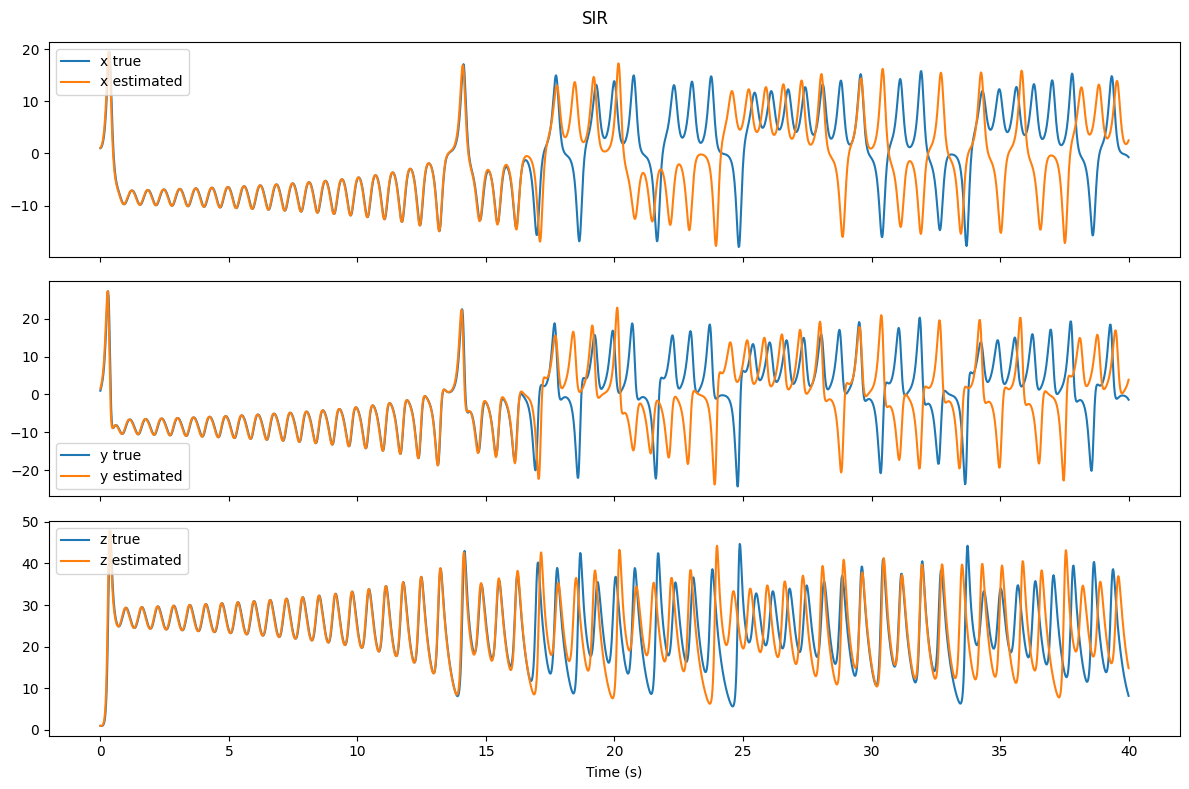

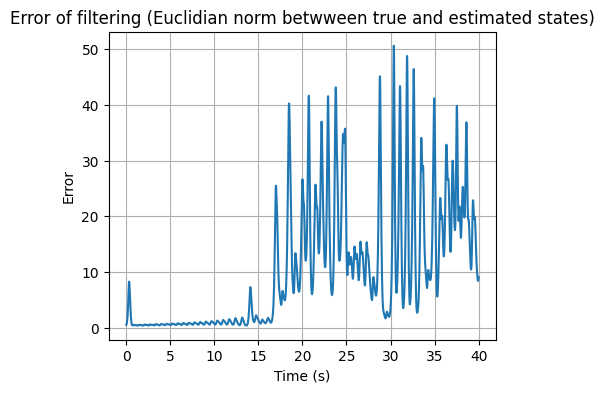

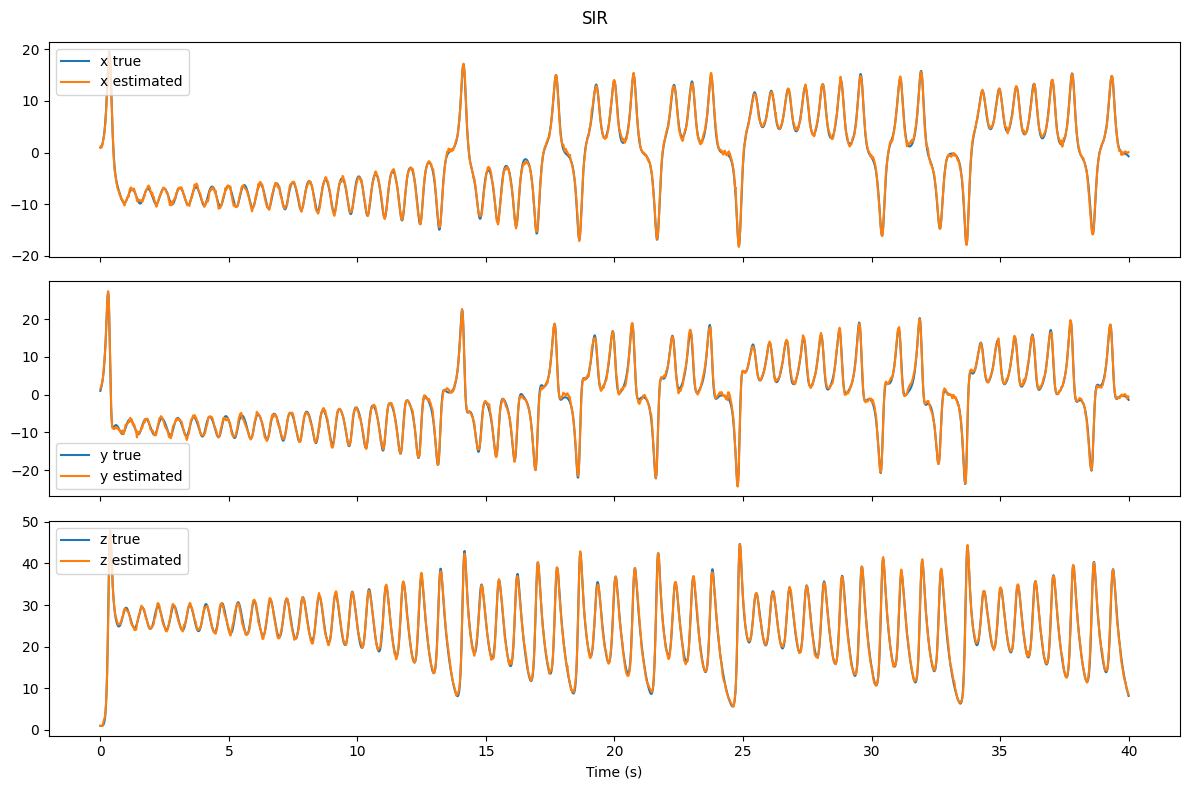

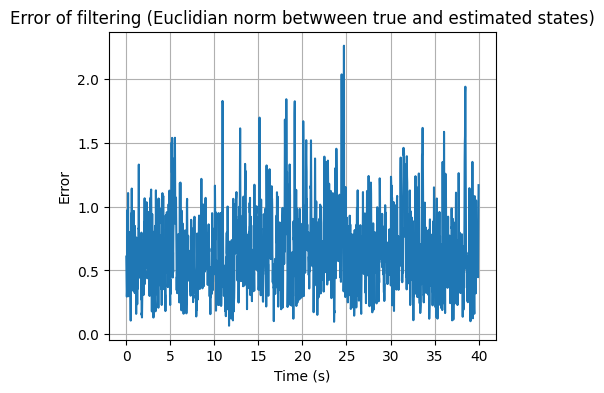

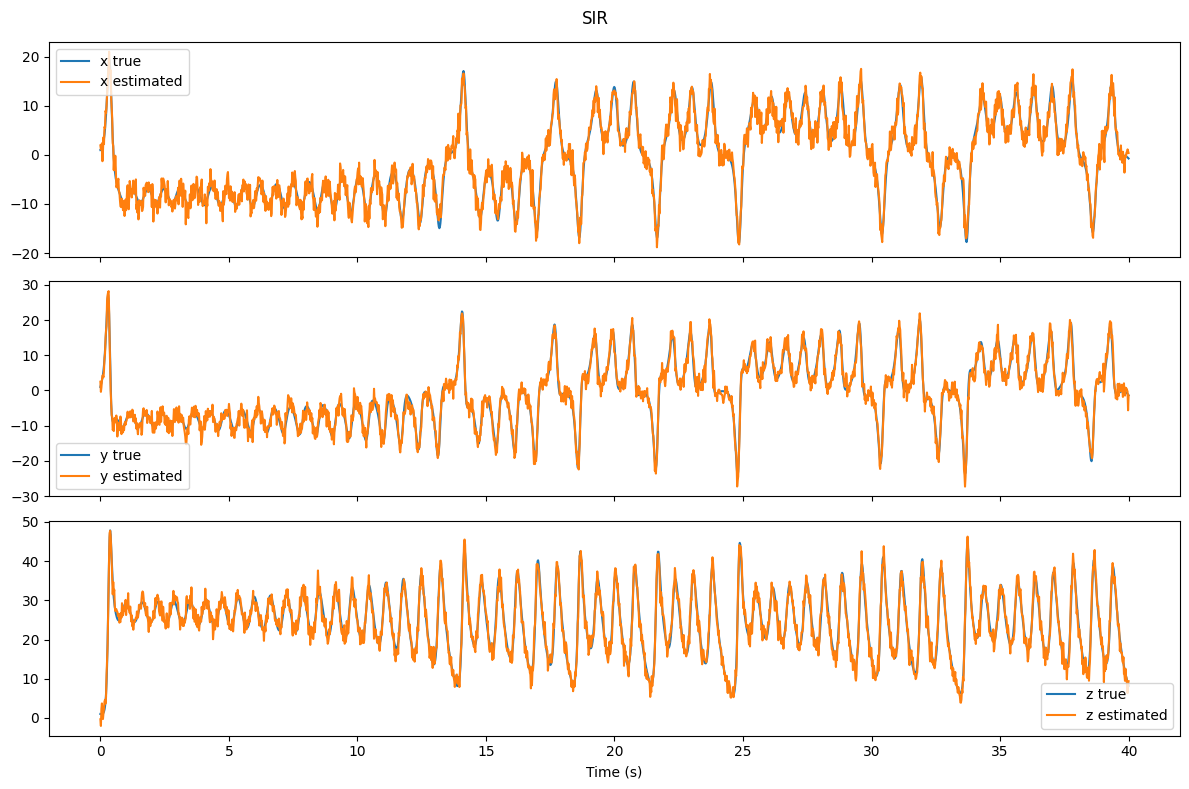

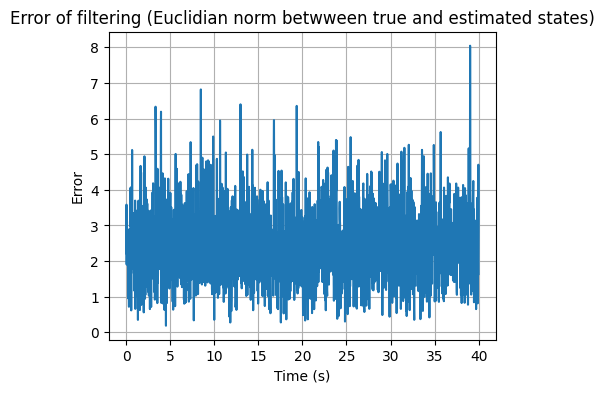

C:\Users\guera\AppData\Local\Temp\ipykernel_16484\621413270.py:14: RuntimeWarning: invalid value encountered in divide
  residuals /= residuals.sum()


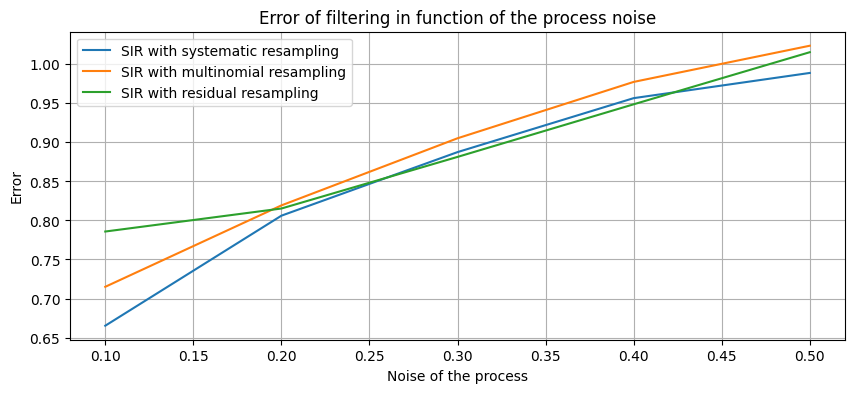

In [ ]:



## What happend if we have a process noise wich is equal to 0 ? 

Sigma_process_noNoise = 0.0 * np.eye(3) # sigma_process = 0.0
SIR(samppling_method='systematic' , graphe=True , Sigma_process=Sigma_process_noNoise, T=40) # sigma_process = 0.0

## What happend if we have a process noise wich is equal to 0.1 ?
Sigma_process_littleNoise = 0.1 * np.eye(3) # sigma_process = 0.1
SIR(samppling_method='systematic' , graphe=True , Sigma_process=Sigma_process_littleNoise, T= 40) # sigma_process = 0.1


Sigma_process_littleNoise = 10 * np.eye(3) # sigma_process = 0.1
SIR(samppling_method='systematic' , graphe=True , Sigma_process=Sigma_process_littleNoise, T = 40 ) # sigma_process = 0.1
## Mean of error for 50 particles in function of the process noise for the multinomial method of resampling 
number = 5
mean_error = np.zeros(number)
mean_error1 = np.zeros(number)
mean_error2 = np.zeros(number)
for i in range(number):
    Sigma_process = (i+1) * 0.1 * np.eye(3) 
    estimated_states, true_states , errors = SIR(samppling_method='systematic' , graphe=False , Sigma_process=Sigma_process) # sigma_process = (i+1) * 0.1
    estimated_states1, true_states1 , errors = SIR(samppling_method='multinomial' , graphe=False , Sigma_process=Sigma_process) # sigma_process = (i+1) * 0.1
    estimated_states2, true_states2 , errors = SIR(samppling_method='residual' , graphe=False , Sigma_process=Sigma_process) # sigma_process = (i+1) * 0.1
    
    
    # Calculate the mean of error for each process noise
    errors = np.linalg.norm(true_states - estimated_states, axis=1)
    errors1 = np.linalg.norm(true_states1 - estimated_states1, axis=1)
    errors2 = np.linalg.norm(true_states2 - estimated_states2, axis=1)
    mean_error[i] = np.mean(errors)
    mean_error1[i] = np.mean(errors1)
    mean_error2[i] = np.mean(errors2)

# Graph of the mean error in function of the process noise
plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, number+1) * 0.1, mean_error)
plt.plot(np.arange(1, number+1) * 0.1, mean_error1)
plt.plot(np.arange(1, number+1) * 0.1, mean_error2)
plt.legend(['SIR with systematic resampling', 'SIR with multinomial resampling', 'SIR with residual resampling'])

plt.title("Error of filtering in function of the process noise")
plt.xlabel("Noise of the process")
plt.ylabel("Error")
plt.grid()
plt.show()

---

## Analyze with different time step

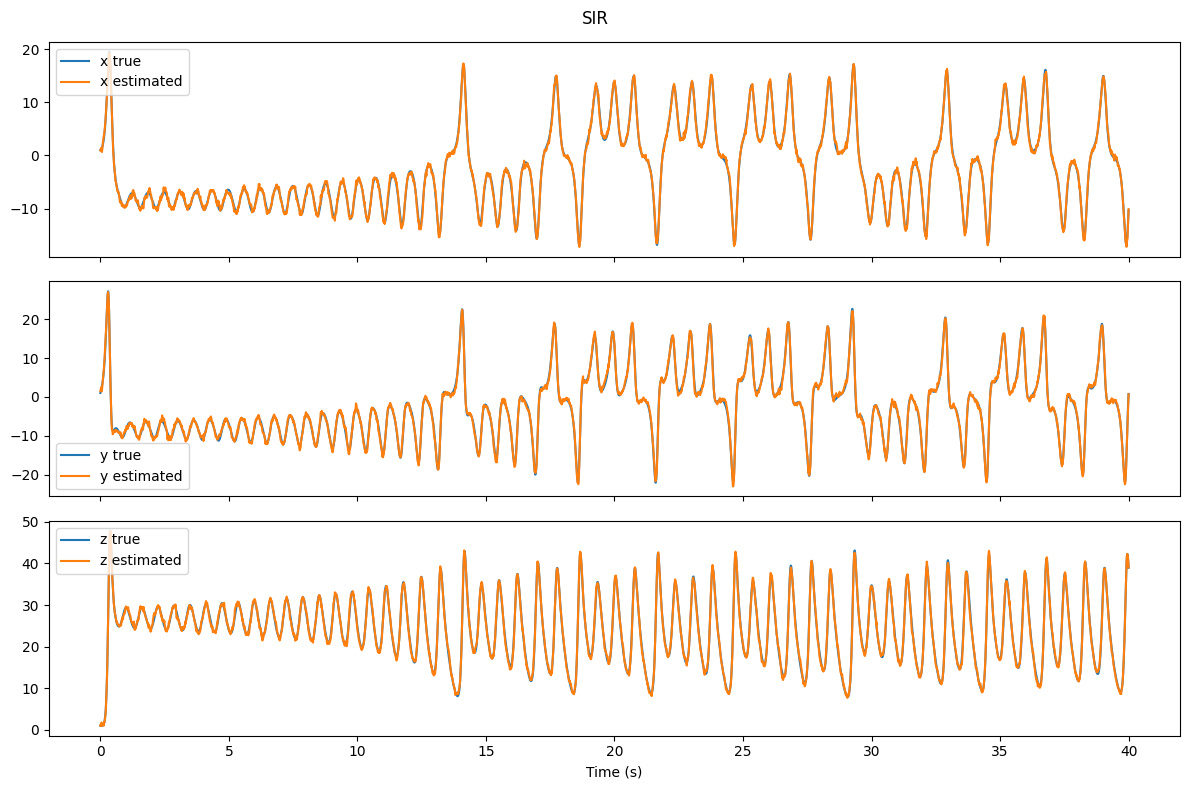

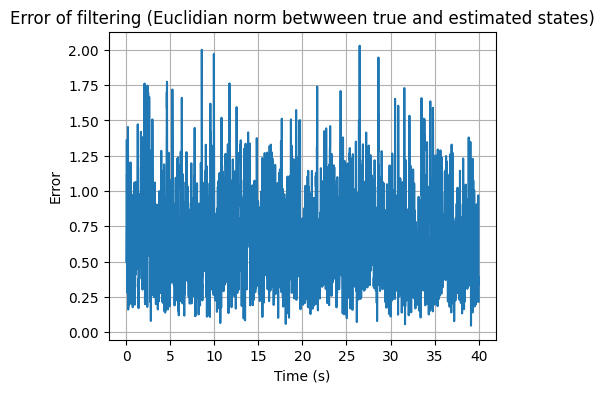

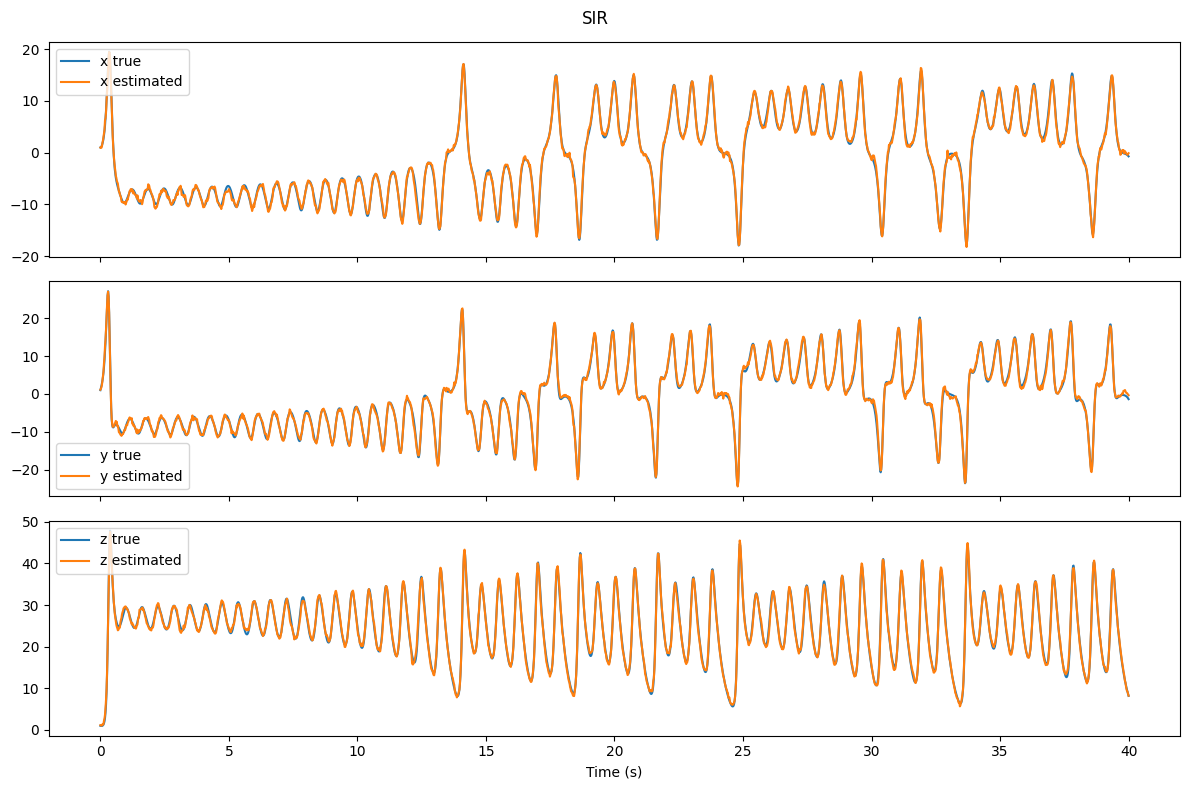

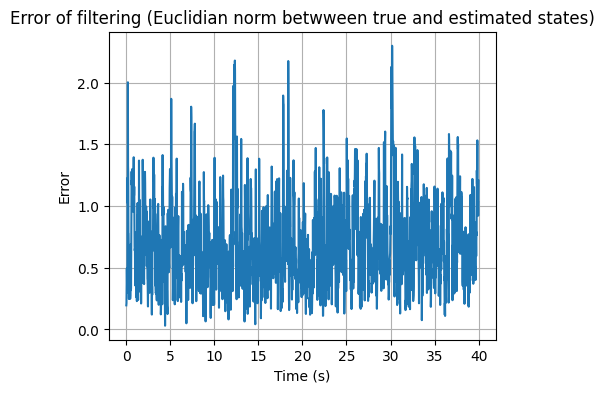

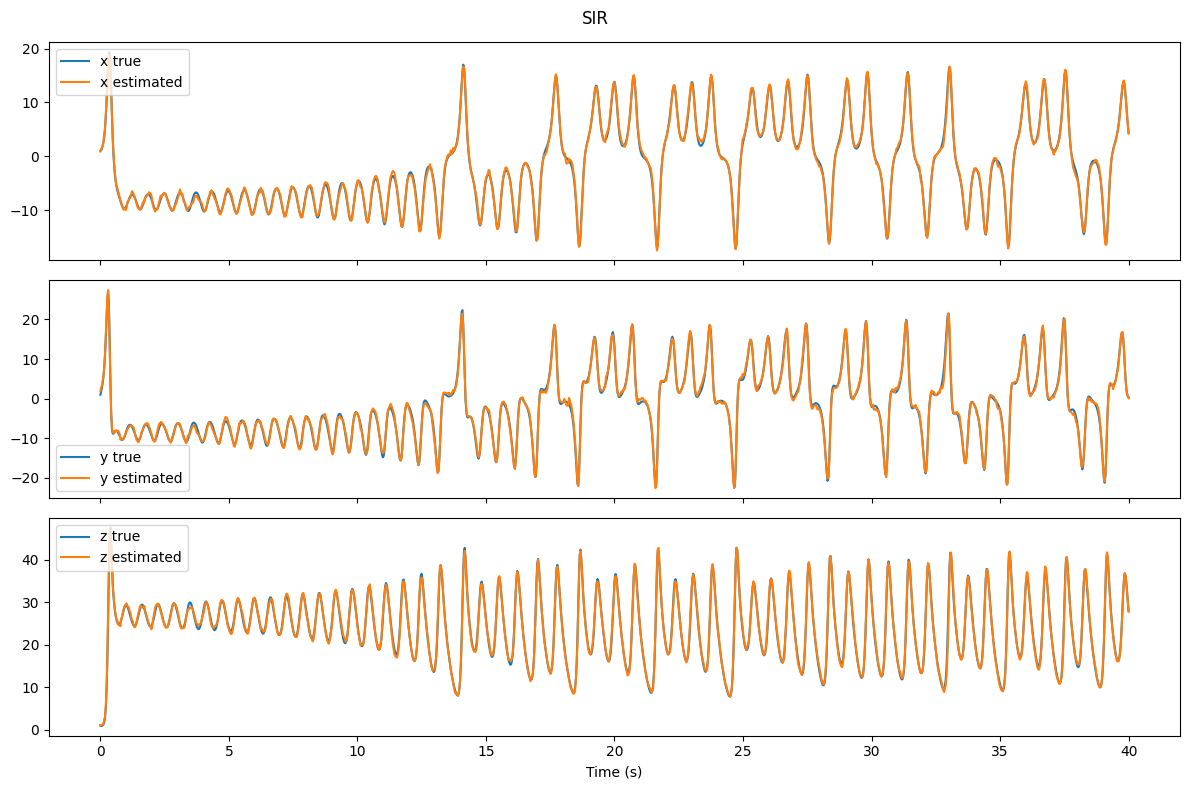

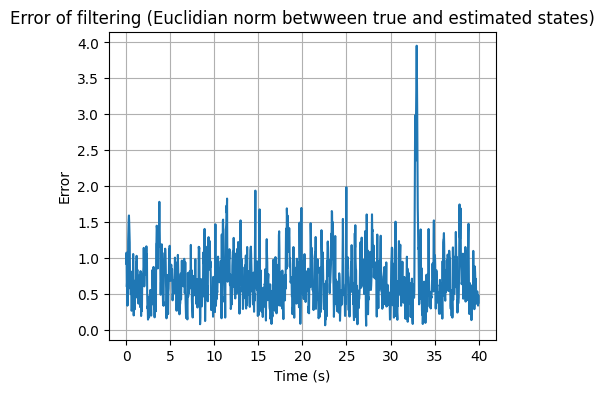

C:\Users\guera\AppData\Local\Temp\ipykernel_12844\621413270.py:14: RuntimeWarning: invalid value encountered in divide
  residuals /= residuals.sum()


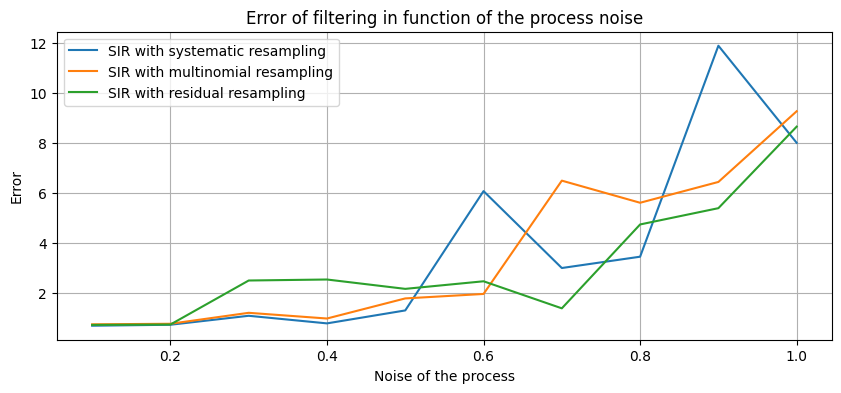

In [7]:
## What happend if we change the time step ? 
h_new = 0.01 # pas de temps
SIR(samppling_method='systematic' , graphe=True , Sigma_process=Sigma_process_basic , h=h_new, T=40) # sigma_process = 0.1
h_new = 0.02
SIR(samppling_method='systematic' , graphe=True , Sigma_process=Sigma_process_basic , h=h_new, T=40) # sigma_process = 0.1
h_new = 0.03 
SIR(samppling_method='systematic' , graphe=True , Sigma_process=Sigma_process_basic , h=h_new, T=40) # sigma_process = 0.1

number = 10
mean_error = np.zeros(number)
mean_error1 = np.zeros(number)
mean_error2 = np.zeros(number)
for i in range(number):
    Sigma_process = (i+1) * 0.01
    estimated_states, true_states , errors = SIR(samppling_method='systematic' , graphe=False , Sigma_process=Sigma_process_basic ,h = Sigma_process ) # sigma_process = (i+1) * 0.1
    estimated_states1, true_states1 , errors = SIR(samppling_method='multinomial' , graphe=False , Sigma_process=Sigma_process_basic ,h = Sigma_process) # sigma_process = (i+1) * 0.1
    estimated_states2, true_states2 , errors = SIR(samppling_method='residual' , graphe=False , Sigma_process=Sigma_process_basic ,h = Sigma_process) # sigma_process = (i+1) * 0.1
    
    
    # Calculate the mean of error for each process noise
    errors = np.linalg.norm(true_states - estimated_states, axis=1)
    errors1 = np.linalg.norm(true_states1 - estimated_states1, axis=1)
    errors2 = np.linalg.norm(true_states2 - estimated_states2, axis=1)
    mean_error[i] = np.mean(errors)
    mean_error1[i] = np.mean(errors1)
    mean_error2[i] = np.mean(errors2)

# Graph of the mean error in function of the process noise
plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, number+1) * 0.1, mean_error)
plt.plot(np.arange(1, number+1) * 0.1, mean_error1)
plt.plot(np.arange(1, number+1) * 0.1, mean_error2)
plt.legend(['SIR with systematic resampling', 'SIR with multinomial resampling', 'SIR with residual resampling'])

plt.title("Error of filtering in function of the process noise")
plt.xlabel("Noise of the process")
plt.ylabel("Error")
plt.grid()
plt.show()



---

## Analyse with different method of resampling


C:\Users\guera\AppData\Local\Temp\ipykernel_16484\621413270.py:14: RuntimeWarning: invalid value encountered in divide
  residuals /= residuals.sum()


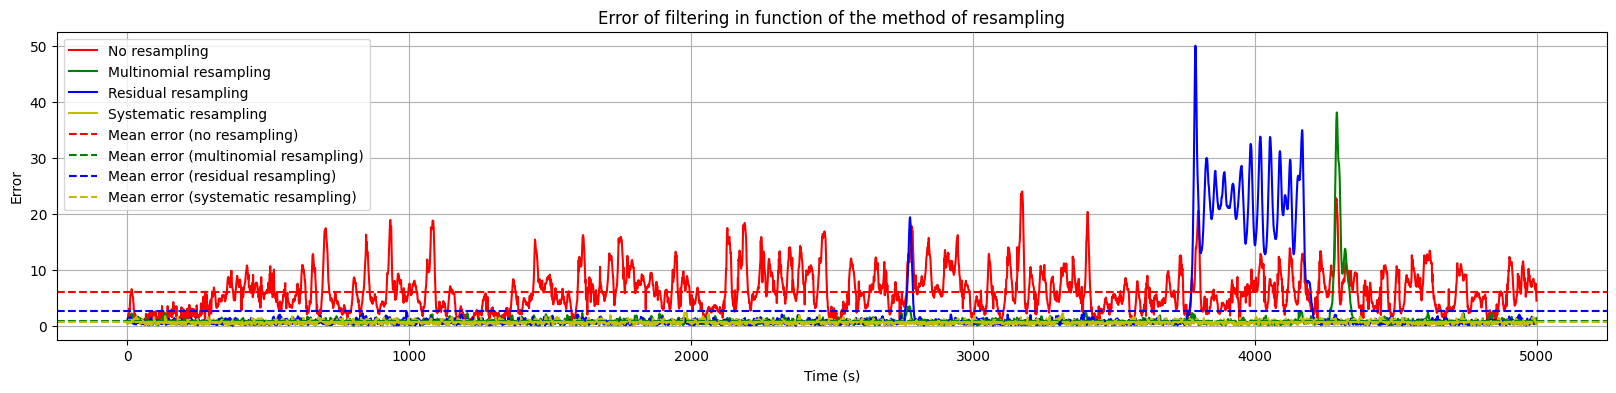

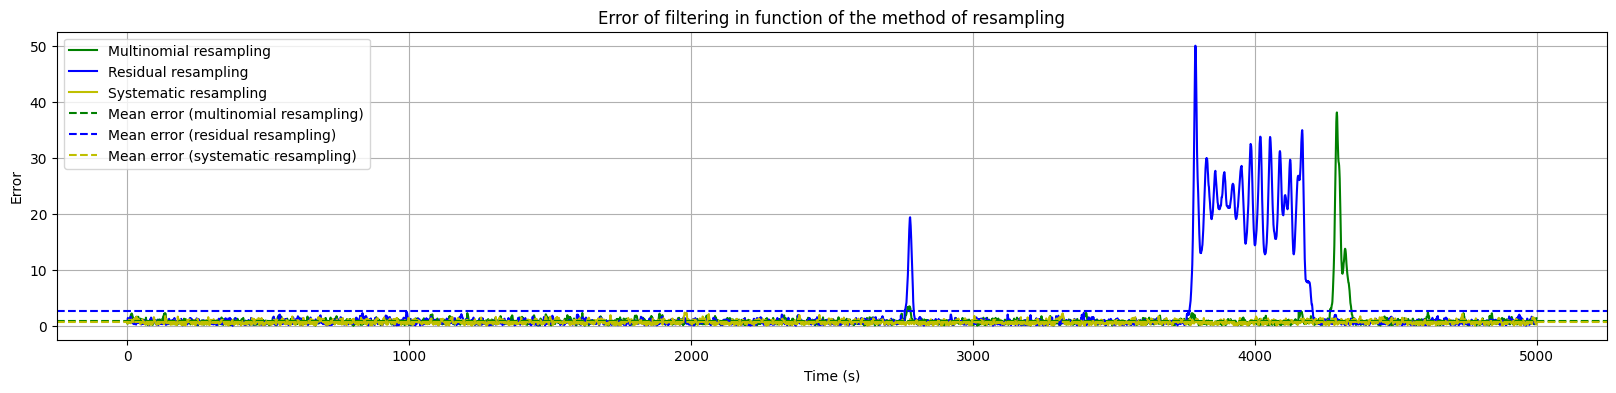

In [ ]:
#What happend if we change the method of resampling ?

no_resampling_estimated_state, no_resampling_true_state, no_resampling_errors = SIR(samppling_method='' , graphe=False , Sigma_process=Sigma_process_basic , h=h_basic) # sigma_process = 0.1
multinomial_estimated_state, multinomial_true_state, multinomial_errors =SIR(samppling_method='multinomial' , graphe=False , Sigma_process=Sigma_process_basic , h=h_basic) # sigma_process = 0.1
residual_estimated_state, residual_true_state, residual_errors =SIR(samppling_method='residual' , graphe=False , Sigma_process=Sigma_process_basic , h=h_basic) # sigma_process = 0.1
systematic_estimated_state, systematic_true_state, systematic_errors =SIR(samppling_method='systematic' , graphe=False , Sigma_process=Sigma_process_basic , h=h_basic) # sigma_process = 0.1

# Plot of errors in function of the method of resampling with mean of errors
plt.figure(figsize=(20, 4))
plt.plot(np.arange(0, len(no_resampling_errors)), no_resampling_errors, label='No resampling' , color= 'r')
plt.plot(np.arange(0, len(no_resampling_errors)), multinomial_errors, label='Multinomial resampling' , color= 'g')
plt.plot(np.arange(0, len(no_resampling_errors)), residual_errors, label='Residual resampling' ,color ='b')
plt.plot(np.arange(0, len(no_resampling_errors)), systematic_errors, label='Systematic resampling' , color= 'y')
plt.title("Error of filtering in function of the method of resampling")
plt.xlabel("Time (s)")
plt.axhline(y=np.mean(no_resampling_errors), color='r', linestyle='--', label='Mean error (no resampling)')
plt.axhline(y=np.mean(multinomial_errors), color='g', linestyle='--', label='Mean error (multinomial resampling)')
plt.axhline(y=np.mean(residual_errors), color='b', linestyle='--', label='Mean error (residual resampling)')
plt.axhline(y=np.mean(systematic_errors), color='y', linestyle='--', label='Mean error (systematic resampling)')
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()
plt.figure(figsize=(20, 4))
plt.plot(np.arange(0, len(no_resampling_errors)), multinomial_errors, label='Multinomial resampling' , color= 'g')
plt.plot(np.arange(0, len(no_resampling_errors)), residual_errors, label='Residual resampling' ,color ='b')
plt.plot(np.arange(0, len(no_resampling_errors)), systematic_errors, label='Systematic resampling' , color= 'y')
plt.title("Error of filtering in function of the method of resampling")
plt.xlabel("Time (s)")
plt.axhline(y=np.mean(multinomial_errors), color='g', linestyle='--', label='Mean error (multinomial resampling)')
plt.axhline(y=np.mean(residual_errors), color='b', linestyle='--', label='Mean error (residual resampling)')
plt.axhline(y=np.mean(systematic_errors), color='y', linestyle='--', label='Mean error (systematic resampling)')
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

---

## Analyse with different number of particles

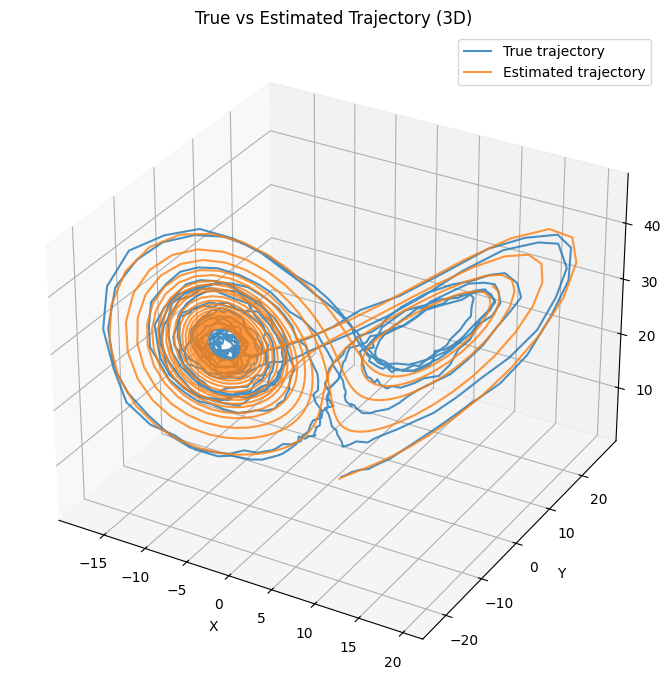

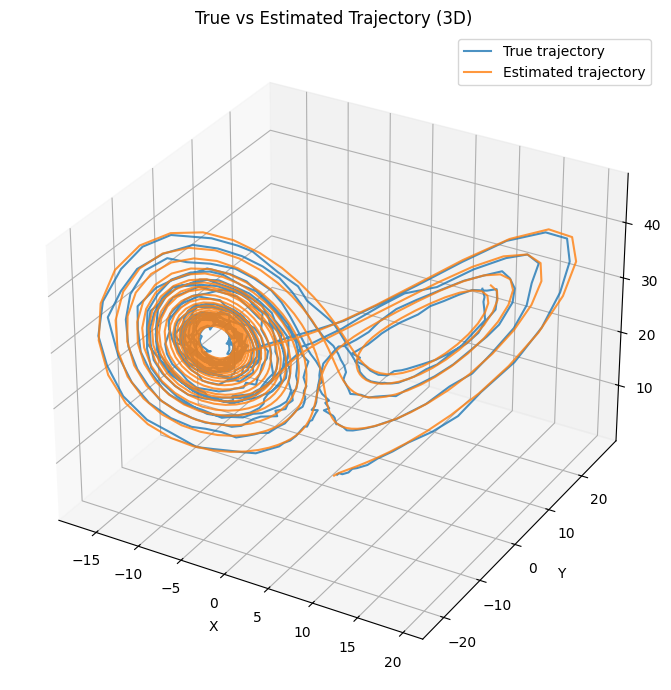

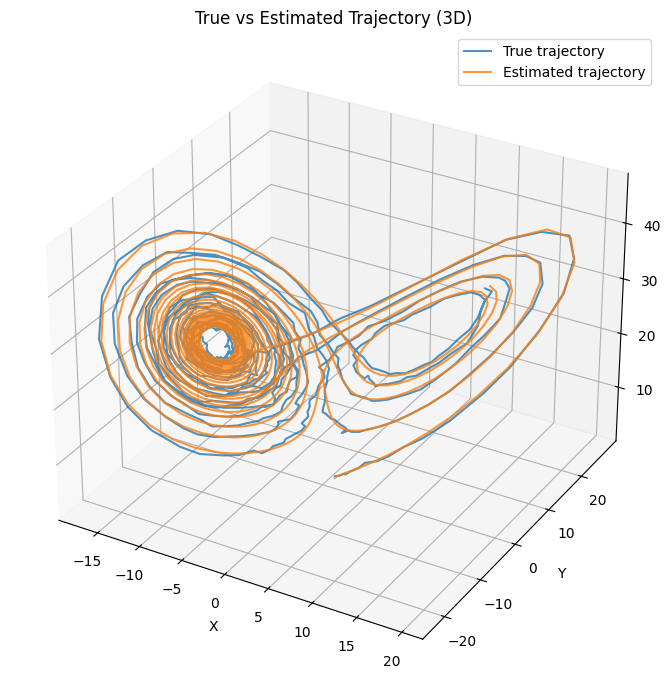

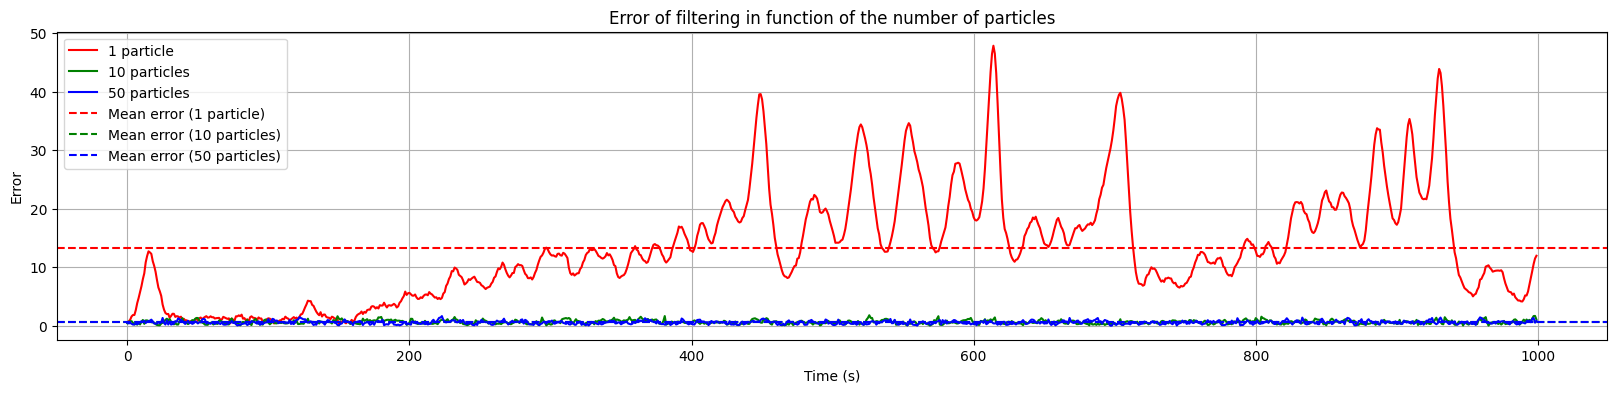

In [ ]:
##What happend if we change the number of particles ?
true_states, estimated_states, errors = SIR(samppling_method='systematic' , graphe=False , Sigma_process=Sigma_process_basic , h=h_basic , num_particles=1 ,T= 20) # sigma_process = 0.1
true_states1, estimated_states1, errors1 = SIR(samppling_method='systematic' , graphe=False , Sigma_process=Sigma_process_basic , h=h_basic , num_particles=10, T =20) # sigma_process = 0.1
true_states2, estimated_states2, errors2 = SIR(samppling_method='systematic' , graphe=False , Sigma_process=Sigma_process_basic , h=h_basic , num_particles=50, T=20) # sigma_process = 0.1

plot_3d_trajectory(true_states, estimated_states)
plot_3d_trajectory(true_states1, estimated_states1)
plot_3d_trajectory(true_states2, estimated_states2)

# Plot of errors in function of the number of particles with mean of errors
plt.figure(figsize=(20, 4))
plt.plot(np.arange(0, len(errors)), errors, label='1 particle' , color= 'r')
plt.plot(np.arange(0, len(errors1)), errors1, label='10 particles' , color= 'g')
plt.plot(np.arange(0, len(errors2)), errors2, label='50 particles' ,color ='b')
plt.title("Error of filtering in function of the number of particles")
plt.xlabel("Time (s)")
plt.axhline(y=np.mean(errors), color='r', linestyle='--', label='Mean error (1 particle)')
plt.axhline(y=np.mean(errors1), color='g', linestyle='--', label='Mean error (10 particles)')
plt.axhline(y=np.mean(errors2), color='b', linestyle='--', label='Mean error (50 particles)')
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

---

## Analyse with a different observation noise

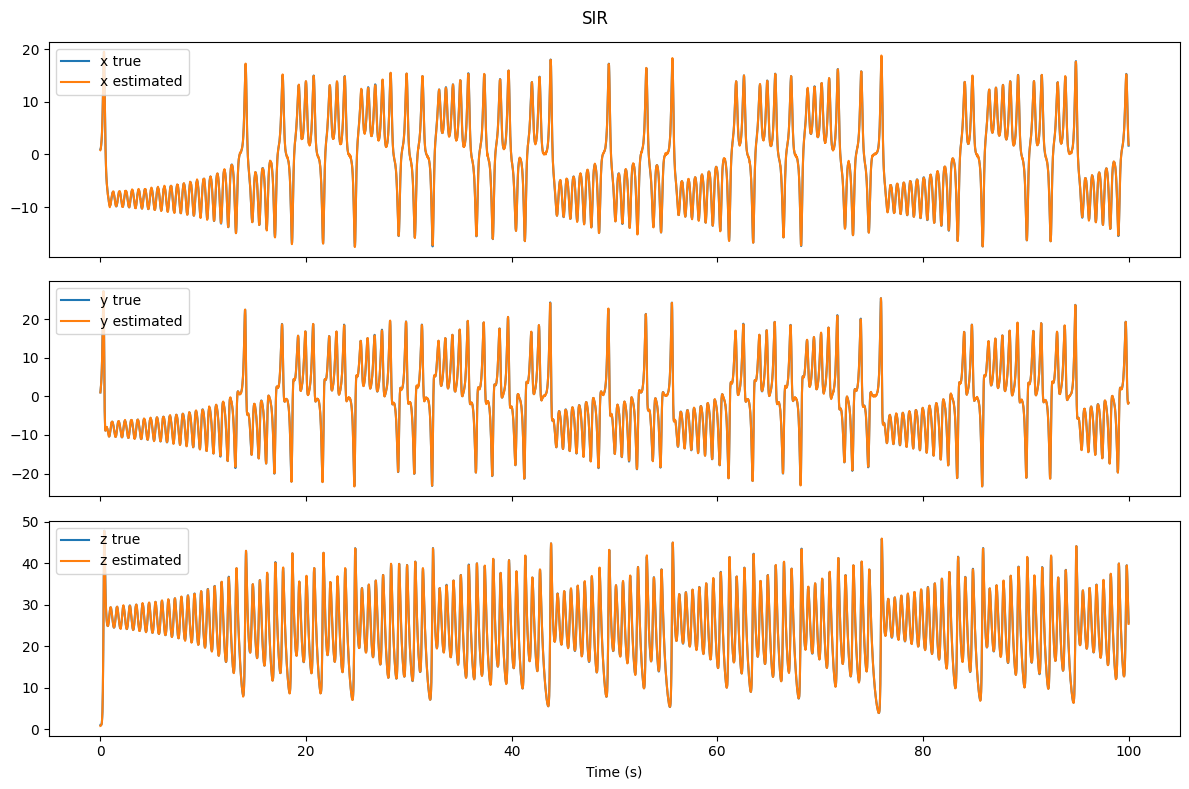

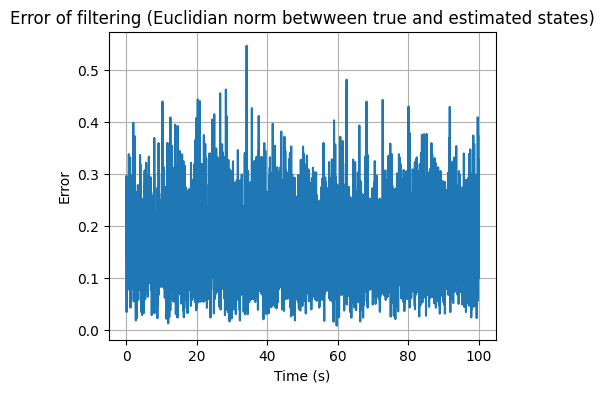

In [ ]:
## what happend if we change the observation noise ?
true_states, estimated_states, errors = SIR(samppling_method='systematic' , graphe=True , Sigma_process=Sigma_process_basic , h=h_basic , num_particles=50 , sigma_obs=0.1) # sigma_process = 0.1
true_states1, estimated_states1, errors1 = SIR(samppling_method='systematic' , graphe=True , Sigma_process=Sigma_process_basic , h=h_basic , num_particles=50 , sigma_obs=0.5) # sigma_process = 0.1

---

## Analyse RMSE et statistique

C:\Users\guera\AppData\Local\Temp\ipykernel_12844\621413270.py:14: RuntimeWarning: invalid value encountered in divide
  residuals /= residuals.sum()


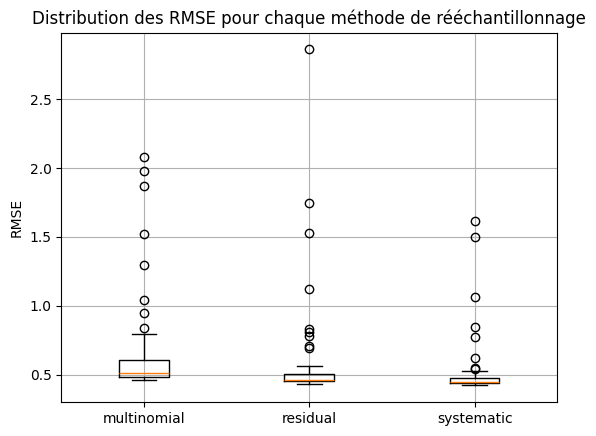

AttributeError: module 'numpy.random' has no attribute 'mtrand'

In [ ]:

def compute_rmse(true_states, estimated_states):
    return np.sqrt(np.mean((true_states - estimated_states)**2))

resampling_methods = ['multinomial', 'residual', 'systematic']
n_runs = 50
rmse_results = {method: [] for method in resampling_methods}

for method in resampling_methods:
    for _ in range(n_runs):
        estimated, true , error = SIR(samppling_method=method, graphe=False)  # Assure-toi que cette fonction retourne bien ces deux tableaux
        rmse = compute_rmse(np.array(true), np.array(estimated))
        rmse_results[method].append(rmse)


import matplotlib.pyplot as plt

plt.boxplot([rmse_results[m] for m in resampling_methods], labels=resampling_methods)
plt.ylabel('RMSE')
plt.title('Distribution des RMSE pour chaque méthode de rééchantillonnage')
plt.grid(True)
plt.show()


